In [ ]:
#hide
from utils import *

# Image classification

## From dogs and cats, to pet breeds

In [ ]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls()

(#3) [Path('annotations'),Path('images'),Path('models')]

In [ ]:
(path/"images").ls()

(#7394) [Path('images/great_pyrenees_173.jpg'),Path('images/wheaten_terrier_46.jpg'),Path('images/Ragdoll_262.jpg'),Path('images/german_shorthaired_3.jpg'),Path('images/american_bulldog_196.jpg'),Path('images/boxer_188.jpg'),Path('images/staffordshire_bull_terrier_173.jpg'),Path('images/basset_hound_71.jpg'),Path('images/staffordshire_bull_terrier_37.jpg'),Path('images/yorkshire_terrier_18.jpg')...]

In [ ]:
fname = (path/"images").ls()[0]

In [ ]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['great_pyrenees']

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

## Presizing

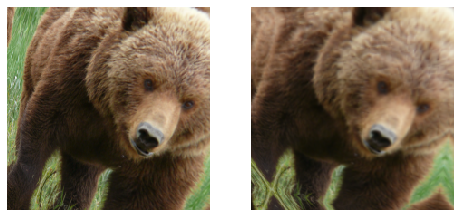

In [ ]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and debugging a DataBlock

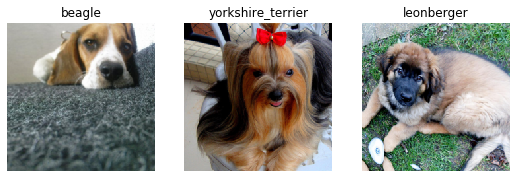

In [ ]:
dls.show_batch(rows=1, cols=3)

In [ ]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/jhoward/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_31.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x414
  Pipeline: partial -> Categorize
    starting from
      /home/jhoward/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_31.jpg
    applying partial gives
      american_pit_bull_terrier
    applying Categorize gives
      TensorCategory(13)

Final sample: (PILImage mode=RGB size=500x414, TensorCategory(13))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=500x414, TensorCategory(13))

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 414 and 375 in dimension 2 at /opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/TH/generic/THTensor.cpp:612

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.491732,0.337355,0.108254,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.503154,0.293404,0.096076,00:23
1,0.314759,0.225316,0.066306,00:23


## Cross entropy loss

### Viewing activations and labels

In [ ]:
x,y = dls.one_batch()

In [ ]:
y

TensorCategory([11,  0,  0,  5, 20,  4, 22, 31, 23, 10, 20,  2,  3, 27, 18, 23, 33,  5, 24,  7,  6, 12,  9, 11, 35, 14, 10, 15,  3,  3, 21,  5, 19, 14, 12, 15, 27,  1, 17, 10,  7,  6, 15, 23, 36,  1, 35,  6,
         4, 29, 24, 32,  2, 14, 26, 25, 21,  0, 29, 31, 18,  7,  7, 17], device='cuda:5')

In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([7.9069e-04, 6.2350e-05, 3.7607e-05, 2.9260e-06, 1.3032e-05, 2.5760e-05, 6.2341e-08, 3.6400e-07, 4.1311e-06, 1.3310e-04, 2.3090e-03, 9.9281e-01, 4.6494e-05, 6.4266e-07, 1.9780e-06, 5.7005e-07,
        3.3448e-06, 3.5691e-03, 3.4385e-06, 1.1578e-05, 1.5916e-06, 8.5567e-08, 5.0773e-08, 2.2978e-06, 1.4150e-06, 3.5459e-07, 1.4599e-04, 5.6198e-08, 3.4108e-07, 2.0813e-06, 8.0568e-07, 4.3381e-07,
        1.0069e-05, 9.1020e-07, 4.8714e-06, 1.2734e-06, 2.4735e-06])

In [ ]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

### Softmax

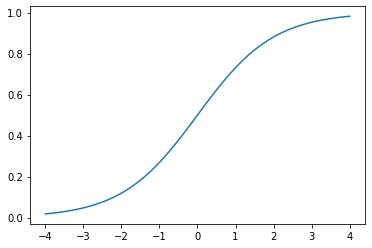

In [ ]:
plot_function(torch.sigmoid, min=-4,max=4)

In [ ]:
#hide
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [ ]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log likelihood

In [ ]:
targ = tensor([0,1,0,1,1,0])

In [ ]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [ ]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [ ]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.99664,0.00336017,1,3,0.00336017
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [ ]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the `log`

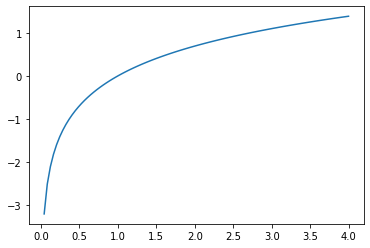

In [ ]:
plot_function(torch.log, min=0,max=4)

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

tensor(1.8045)

In [ ]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

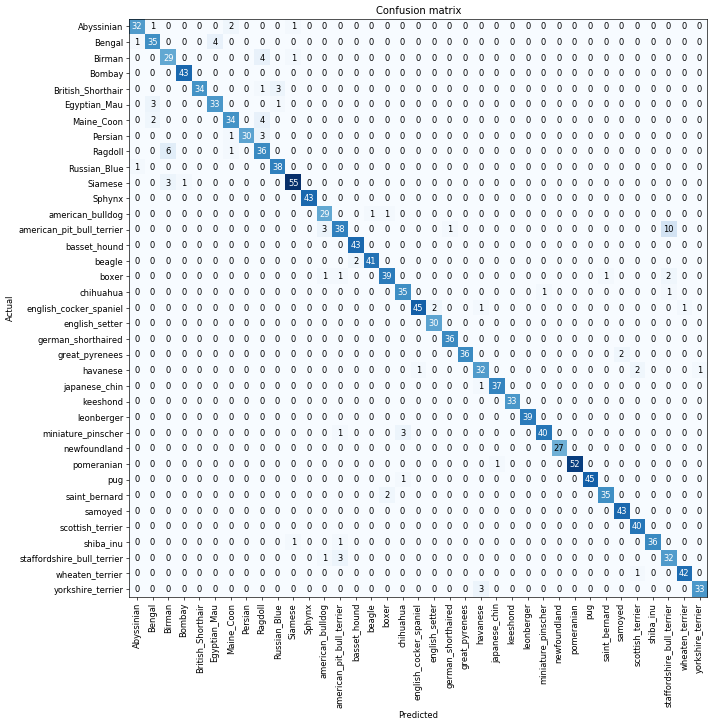

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('Ragdoll', 'Birman', 6)]

## Improving our model

### Learning rate finder

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,8.946717,47.954632,0.893775,00:20


epoch,train_loss,valid_loss,error_rate,time
0,7.231843,4.119265,0.954668,00:24


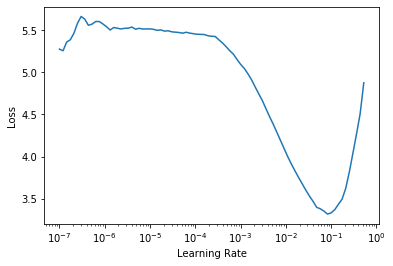

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 6.31e-03


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.071820,0.427476,0.133965,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.738273,0.541828,0.150880,00:24
1,0.401544,0.266623,0.081867,00:24


### Unfreezing and transfer learning

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.188042,0.355024,0.102842,00:20
1,0.534234,0.302453,0.094723,00:20
2,0.325031,0.222268,0.074425,00:20


In [ ]:
learn.unfreeze()

(1.0964782268274575e-05, 1.5848931980144698e-06)

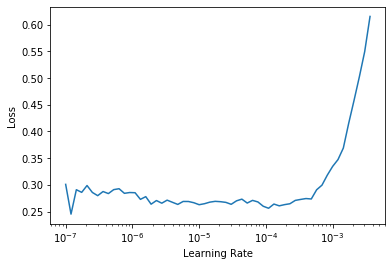

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.263579,0.217419,0.069012,00:24
1,0.253060,0.210346,0.062923,00:24
2,0.224340,0.207357,0.060217,00:24
3,0.200195,0.207244,0.061570,00:24
4,0.194269,0.200149,0.059540,00:25
5,0.173164,0.202301,0.059540,00:25


### Discriminative learning rates

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.145300,0.345568,0.119756,00:20
1,0.533986,0.251944,0.077131,00:20
2,0.317696,0.208371,0.069012,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.257977,0.205400,0.067659,00:25
1,0.246763,0.205107,0.066306,00:25
2,0.240595,0.193848,0.062246,00:25
3,0.209988,0.198061,0.062923,00:25
4,0.194756,0.193130,0.064276,00:25
5,0.169985,0.187885,0.056157,00:25
6,0.153205,0.186145,0.058863,00:25
7,0.141480,0.185316,0.053451,00:25
8,0.128564,0.180999,0.051421,00:25
9,0.126941,0.186288,0.054127,00:25


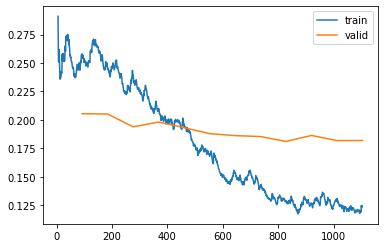

In [ ]:
learn.recorder.plot_loss()

### Selecting the number of epochs

### Deeper architectures

In [ ]:
from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.427505,0.310554,0.098782,00:21
1,0.606785,0.302325,0.094723,00:22
2,0.409267,0.294803,0.091340,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.261121,0.274507,0.083897,00:26
1,0.296653,0.318649,0.084574,00:26
2,0.242356,0.253677,0.069012,00:26
3,0.150684,0.251438,0.065629,00:26
4,0.094997,0.239772,0.064276,00:26
5,0.061144,0.228082,0.054804,00:26


## Summary

## Questionnaire

### Further research